# Train a deep CNN on XPS data on local machine

In this notebook, we will train a deep convolutional network on iron XPS spectra using the local CPU/GPU.

## Setup

In [1]:
# Imports
%matplotlib inline
import os
import datetime
import pytz
import numpy as np
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Run tensorflow on local CPU
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

# Disable tf warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'


# Import custom classes
from network.classifier import Classifier
from network.utils import TrainingGraphs, Report

## Initial run

### Setting up the parameters & folder structure

In [2]:
np.random.seed(502)
time =  datetime.datetime.now().astimezone(pytz.timezone('Europe/Berlin')).strftime("%Y%m%d_%Hh%Mm")
model_type = 'CNN_simple'
model_name = 'Fe_single_4_classes_CNN_simple'

label_values = ['Fe metal', 'FeO', 'Fe3O4', 'Fe2O3']

clf = Classifier(time = time,
                 model_type = model_type,
                 model_name = model_name,
                 labels = label_values)

Model folder created at \saved_models\20200623_16h49m_Fe_single_4_classes_CNN_simple
Log folder created at \logs\20200623_16h49m_Fe_single_4_classes_CNN_simple
Figure folder created at \figures\20200623_16h49m_Fe_single_4_classes_CNN_simple


### Load and inspect the data

Data was loaded!
Total no. of samples: 1000
No. of training samples: 640
No. of validation samples: 160
No. of test samples: 200
Shape of each sample : 1121 features (X) + 4 labels (y)


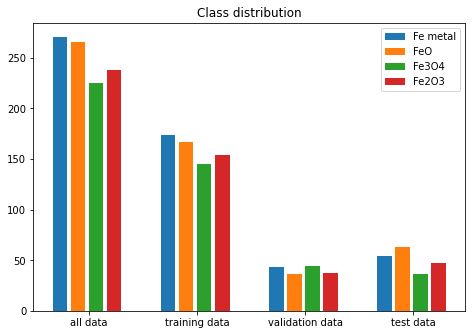

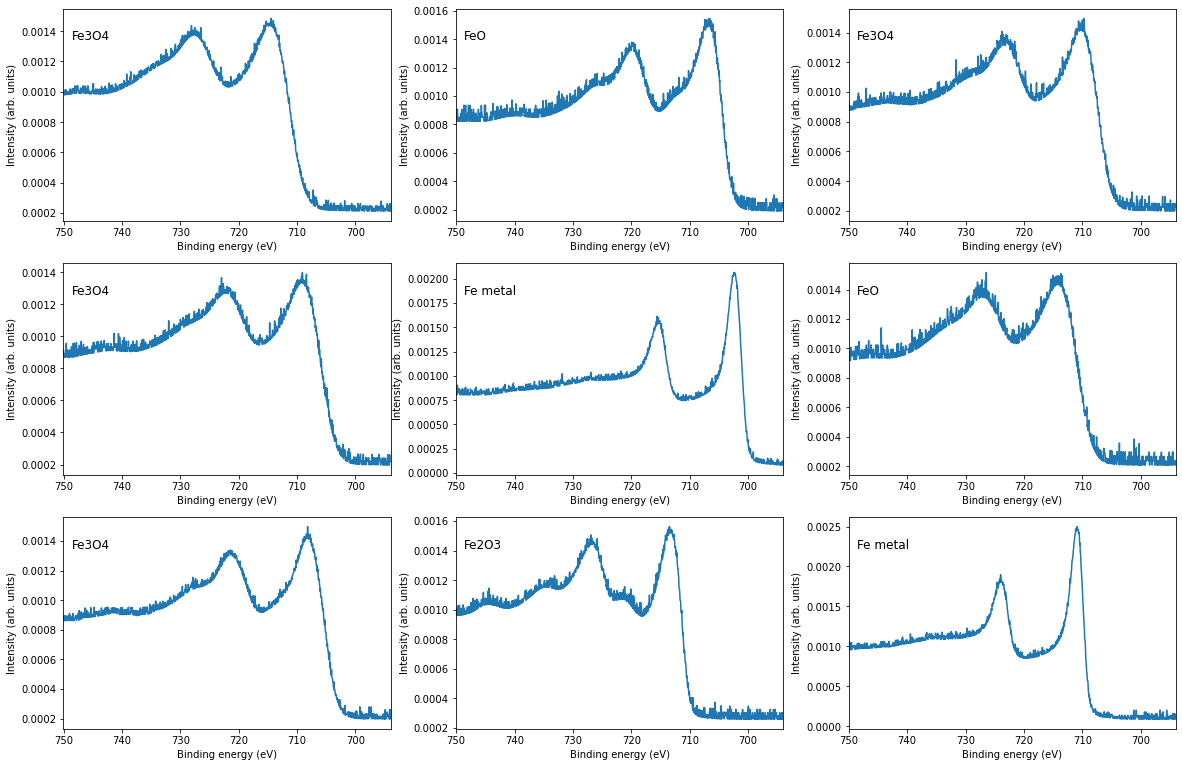

In [3]:
input_filepath = r'C:\Users\pielsticker\Simulations\20200605_iron_single_small.h5'   
train_test_split = 0.2
train_val_split = 0.2
no_of_examples = 1000

X_train, X_val, X_test, y_train, y_val, y_test = clf.load_data_preprocess(input_filepath = input_filepath,
                                                                          no_of_examples = no_of_examples,
                                                                          train_test_split = train_test_split,
                                                                          train_val_split = train_val_split)
# Check how the examples are distributed across the classes:
class_distribution = clf.check_class_distribution()
clf.plot_class_distribution()
clf.plot_random(no_of_spectra = 9, dataset = 'train')  

### Build the model

Model: "Custom_CNN_simple"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 1113, 32)          320       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1105, 64)          18496     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 552, 64)           0         
_________________________________________________________________
dropout (Dropout)            (None, 552, 64)           0         
_________________________________________________________________
flatten (Flatten)            (None, 35328)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               4522112   
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)         

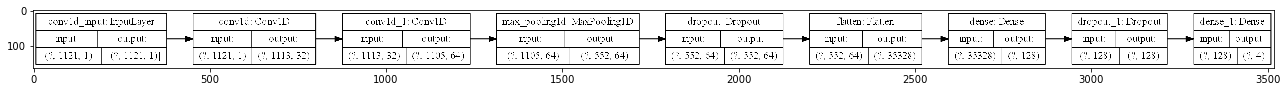

In [4]:
learning_rate = 1e-05

clf.build_model(learning_rate)
clf.summary()
clf.save_and_print_model_image()

### Training

In [5]:
epochs = 2
batch_size = 32

hist = clf.train(checkpoint = True,
                 early_stopping = False,
                 tb_log = True, 
                 csv_log = True,
                 epochs = epochs, 
                 batch_size = batch_size,
                 verbose = 1)

Train on 640 samples, validate on 160 samples
Epoch 1/2
608/640 [===========================>..] - ETA: 0s - loss: 1.3863 - accuracy: 0.2582WARNING:tensorflow:From C:\Users\pielsticker\Anaconda3\envs\xps\lib\site-packages\tensorflow_core\python\ops\resource_variable_ops.py:1786: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: C:\Users\pielsticker\Lukas\MPI-CEC\Projects\xpsdeeplearning\saved_models\20200623_16h49m_Fe_single_4_classes_CNN_simple\assets
640/640 [==============================] - 6s 9ms/sample - loss: 1.3863 - accuracy: 0.2578 - val_loss: 1.3863 - val_accuracy: 0.3562
Epoch 2/2
640/640 [==============================] - 10s 16ms/sample - loss: 1.3863 - accuracy: 0.2937 - val_loss: 1.3863 - val_accuracy: 0.3438
Training done!


### Graphs

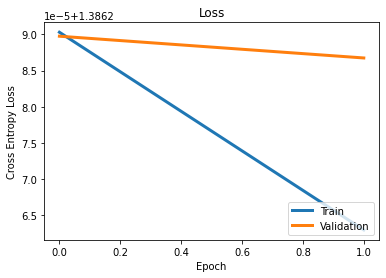

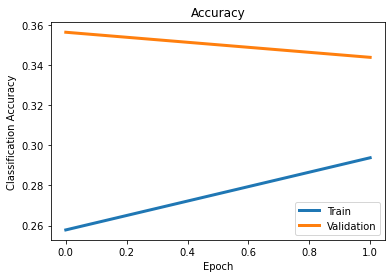

In [6]:
graph = TrainingGraphs(clf.history,
                        clf.model_name,
                        clf.time) 

### Evaluation on test data

In [7]:
score = clf.evaluate()
test_loss, test_accuracy = score[0], score[1]
print('Test loss: ' + str(np.round(test_loss, decimals=3)))
print('Test accuracy: ' + str(np.round(test_accuracy, decimals=3)))

200/200 [==============================] - 1s 5ms/sample - loss: 1.3862 - accuracy: 0.3700
Evaluation done! 

Test loss: 1.386
Test accuracy: 0.37


### Prediction on test data

In [8]:
pred_train, pred_test = clf.predict()
pred_train_classes, pred_test_classes = clf.predict_classes()

200/200 [==============================] - 0s 1ms/sample
Prediction done!
Class prediction done!


### Show some predictions

#### Training data

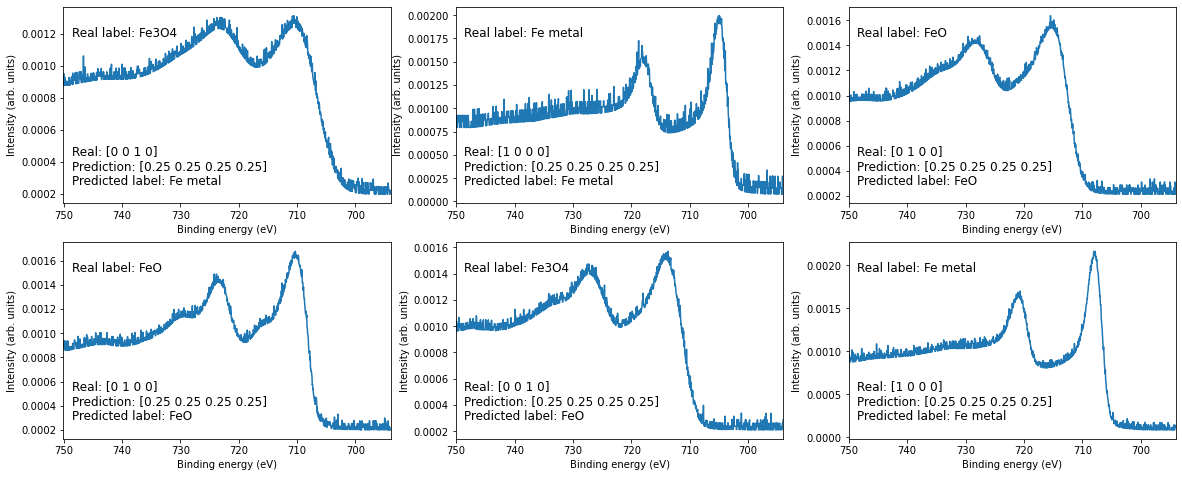

In [9]:
clf.plot_random(no_of_spectra = 6, dataset = 'train', with_prediction = True)  

#### Test data

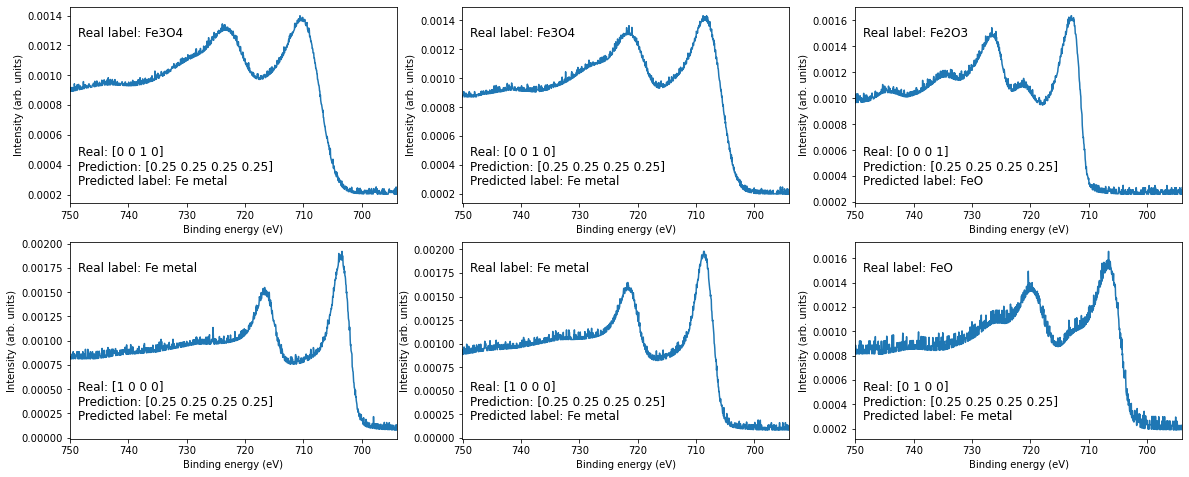

In [10]:
clf.plot_random(no_of_spectra = 6, dataset = 'test', with_prediction = True)  

### Saving data

In [11]:
clf.save_model()
clf.shelve_results(full = False)  

INFO:tensorflow:Assets written to: C:\Users\pielsticker\Lukas\MPI-CEC\Projects\xpsdeeplearning\saved_models\20200623_16h49m_Fe_single_4_classes_CNN_simple\assets
Saved model and hyperparameters.


### Report

In [12]:
dir_name = clf.time + '_' + clf.model_name
rep = Report(dir_name)  
rep.write()   

Report saved!


## Continue training 

Loaded model from disk.
New learning rate: 1e-04
Train on 640 samples, validate on 160 samples
Epoch 5/6
640/640 [==============================] - 8s 13ms/sample - loss: 1.3867 - accuracy: 0.2625 - val_loss: 1.3867 - val_accuracy: 0.2688
Epoch 6/6
640/640 [==============================] - 6s 10ms/sample - loss: 1.3856 - accuracy: 0.2484 - val_loss: 1.3867 - val_accuracy: 0.2688
Training done!


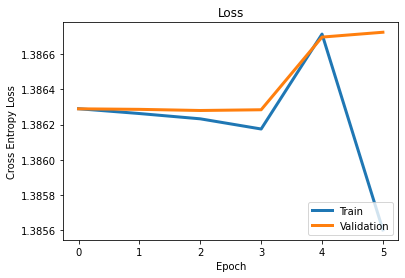

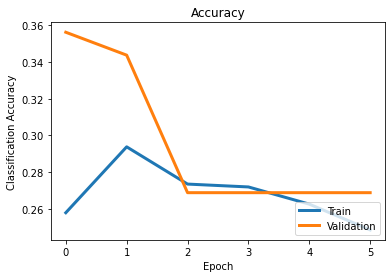

200/200 [==============================] - 1s 4ms/sample - loss: 1.3835 - accuracy: 0.2700
Evaluation done! 

200/200 [==============================] - 0s 2ms/sample
Prediction done!
Class prediction done!
INFO:tensorflow:Assets written to: C:\Users\pielsticker\Lukas\MPI-CEC\Projects\xpsdeeplearning\saved_models\20200623_16h49m_Fe_single_4_classes_CNN_simple\assets
Saved model and hyperparameters.
Report saved!


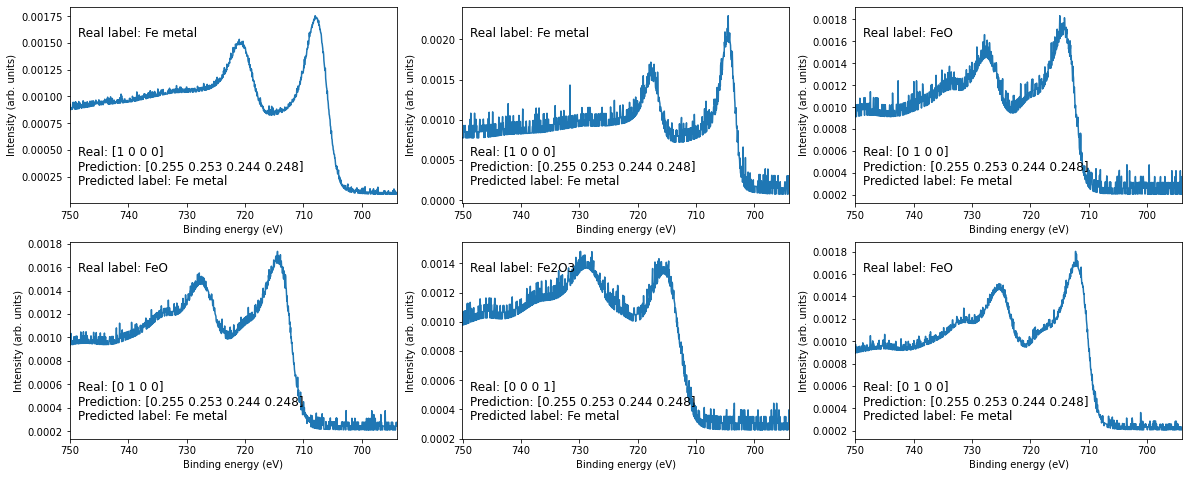

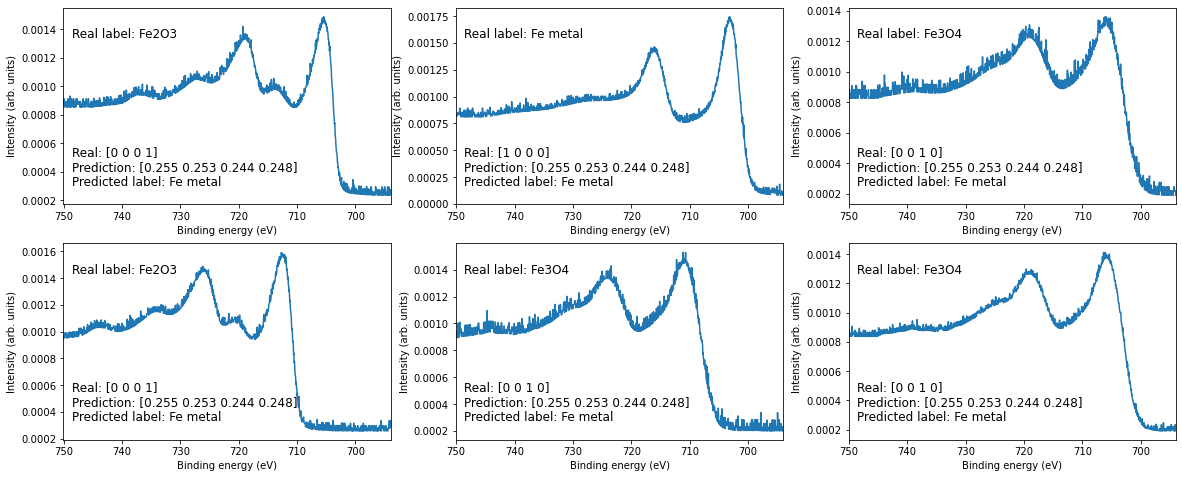

In [17]:
# Reload and train for more epochs
clf.load_model(from_path = False)
# model_path = r'C:\Users\pielsticker\Lukas\MPI-CEC\Projects\xpsdeeplearning\saved_models\20200608_17h51m_Fe_single_4_classes_CNN_simple' 
# clf.load_model(from_path = True, model_path = model_path)
new_learning_rate = 1e-04
epochs = 2
batch_size = 32
hist = clf.train(checkpoint = True,
                 early_stopping = False,
                 tb_log = True, 
                 csv_log = True,
                 epochs = epochs,
                 batch_size = batch_size, 
                 new_learning_rate = new_learning_rate) # Learning rate can be changed for retraining
graphs = TrainingGraphs(hist,clf.model_name, clf.time)

score = clf.evaluate()
test_loss, test_accuracy = score[0], score[1]

pred_train, pred_test = clf.predict()
pred_train_classes, pred_test_classes = clf.predict_classes()
clf.plot_random(no_of_spectra = 6, dataset = 'train', with_prediction = True)  
clf.plot_random(no_of_spectra = 6, dataset = 'test', with_prediction = True)  

clf.save_model()
clf.shelve_results(full = False)  

dir_name = clf.time + '_' + clf.model_name
rep = Report(dir_name)  
rep.write()  


### Save output of notebook

In [18]:
from IPython.display import Javascript, display
from nbconvert import HTMLExporter

def save_notebook():
    display(Javascript("IPython.notebook.save_notebook()"), include=['application/javascript'])

def output_HTML(read_file, output_file):
    import codecs
    import nbformat
    exporter = HTMLExporter()
    # read_file is '.ipynb', output_file is '.html'
    output_notebook = nbformat.read(read_file, as_version=4)
    output, resources = exporter.from_notebook_node(output_notebook)
    codecs.open(output_file, 'w', encoding='utf-8').write(output)

import time

save_notebook()
time.sleep(3)
current_file = 'train_local.ipynb'
output_file = os.path.join(clf.log_dir,'train_local_out.html')
output_HTML(current_file, output_file)

In [19]:
from tensorflow.keras import backend as K
print('New learning rate: ' +\
      str(K.eval(clf.model.optimizer.lr)))

New learning rate: 1e-04
